# Setup

In [182]:
# Imports
import os
import sklearn as skl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# I'm working across multiple devices. So, this code will always create a path to the folder containing the data.
data_folder_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "instacart-market-basket-analysis")
data_folder_path

'C:\\Users\\ryan.mcneil\\Documents\\Projects\\CSC84040\\instacart-market-basket-analysis'

# Part A: Exploratory Data Analysis
1. Perform Exploratory Data Analysis (EDA) and discuss the data and what you observe
prior to beginning modeling and how the EDA insights impact how to proceed 

### Aisles

In [183]:
aisles = pd.read_csv(os.path.join(data_folder_path, "aisles.csv"))

In [184]:
print(f"No duplicate aisles: {len(pd.unique(aisles.aisle)) == len(aisles.aisle)}")

print(f"NA values: {aisles.isnull().sum().sum()}")

aisles.head()

No duplicate aisles: True
NA values: 0


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


Aisles appears to be a table of aisles (by name (str)) with unique id numbers assigned to each.

### Departments

In [185]:
departments = pd.read_csv(os.path.join(data_folder_path, "departments.csv"))

In [205]:
print(f"Unique departments {departments.__len__()}") # here len = nunique departments so long as duplicates == 0
print(f"No duplicate departments: {len(pd.unique(departments.department)) == len(departments.department)}")
print(f"NA values: {departments.isnull().sum().sum()}")

departments.head()

Unique departments 21
No duplicate departments: True
NA values: 0


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


Departments appears to be a table of departments (by name (str)) with unique id numbers assigned to each.

### Order_products__prior

In [187]:
order_products__prior = pd.read_csv(os.path.join(data_folder_path, "order_products__prior.csv"))

In [188]:
print(f"NA values: {order_products__prior.isnull().sum().sum()}")

print(f"Orders in dataset: {order_products__prior.order_id.nunique()}")

print(f"Frequency of reorder: {round(order_products__prior.reordered.mean(), 4) * 100}%")

order_products__prior.head()

NA values: 0
Orders in dataset: 3214874
Frequency of reorder: 58.97%


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


order_products__prior appears to be a table of products previously ordered by order (for ~3.4 million orders), including the order in which each product was added to cart & a binary flag for whether that product was previously ordered by that customer.

Median add_to_cart_order: 6.0


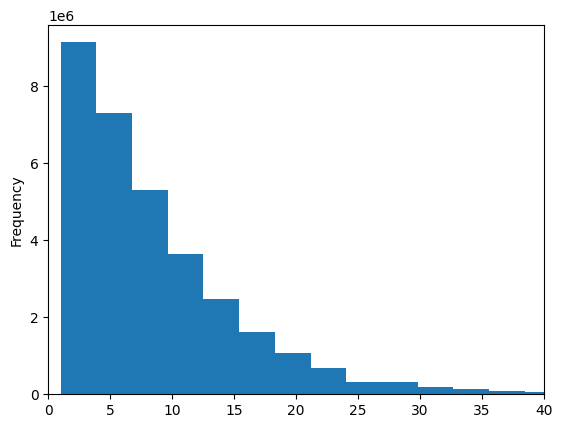

In [189]:
print(f"Median add_to_cart_order: {order_products__prior['add_to_cart_order'].median()}")
order_products__prior['add_to_cart_order'].plot.hist(bins=50)
plt.xlim(0, 40)
plt.show()

The max add_to_cart order is 145, but there are several outliers, so I clip my graph at 40 to see where most rows fall. The frequency of add_to_cart_order values seems to drop quickly. 
Given these outliers, I also look at the median instead of the mean. This shows that "most" items are added to an order in position 6 or less.

In [190]:
print(f"Median number of orders containing each product: {order_products__prior['product_id'].value_counts().median()}")
order_products__prior['product_id'].value_counts().sort_index()

Median number of orders containing each product: 60.0


product_id
1        1852
2          90
3         277
4         329
5          15
         ... 
49684       9
49685      49
49686     120
49687      13
49688      89
Name: count, Length: 49677, dtype: int64

Value counts of product_id shows that most products are represented in 60 or fewer orders, however a few products are extreme outliers. These may need to be dropped to produce a strong predictive model.

### Order_products__train

In [191]:
order_products__train = pd.read_csv(os.path.join(data_folder_path, "order_products__train.csv"))

In [192]:
print(f"NA values: {order_products__train.isnull().sum().sum()}")

print(f"Orders in dataset: {order_products__train.order_id.nunique()}")

print(f"Frequency of reorder: {round(order_products__train.reordered.mean(), 4) * 100}%")

print(f"Comparative size: {round((order_products__train.__len__() / order_products__prior.__len__()) * 100, 2)}%")

order_products__train.head()

NA values: 0
Orders in dataset: 131209
Frequency of reorder: 59.86%
Comparative size: 4.27%


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


order_products__train appears to be a training set of data of the same structure as order_produces_prior, but only contains 4.27% as much data. 

### Orders

In [193]:
orders = pd.read_csv(os.path.join(data_folder_path, "orders.csv"))

In [194]:
print(f"NA values: {orders.isnull().sum().sum()}")
print(f"Proportion of NAs {round(100 * orders.isnull().sum().sum()/orders.__len__(), 2)}%")
print(f"Orders in dataset: {orders.order_id.nunique()}")
print(f"Duplicate orders: {orders['order_id'].duplicated().sum()}")
orders[orders['days_since_prior_order'].isna()]

NA values: 206209
Proportion of NAs 6.03%
Orders in dataset: 3421083
Duplicate orders: 0


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
11,2168274,2,prior,1,2,11,NaN
26,1374495,3,prior,1,1,14,NaN
39,3343014,4,prior,1,6,11,NaN
45,2717275,5,prior,1,3,12,NaN
...,...,...,...,...,...,...,...
3420930,969311,206205,prior,1,4,12,NaN
3420934,3189322,206206,prior,1,3,18,NaN
3421002,2166133,206207,prior,1,6,19,NaN
3421019,2227043,206208,prior,1,1,15,NaN


In [195]:
orders[(orders['days_since_prior_order'].isna()) & (orders['eval_set'] != 'prior')].sum().sum()
# filter for days_since_prior_order is na & eval_set not 'prior'

np.float64(0.0)

All rows containing NAs are apparently part of the 'prior' set. No NAs (from this file, at least) in the train or test sets.

In [196]:
orders.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.214874e+06
mean,1.710542e+06,1.029782e+05,1.715486e+01,2.776219e+00,1.345202e+01,1.111484e+01
std,9.875817e+05,5.953372e+04,1.773316e+01,2.046829e+00,4.226088e+00,9.206737e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.552715e+05,5.139400e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.710542e+06,1.026890e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.565812e+06,1.543850e+05,2.300000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01


Orders contains items ordered categorized into the "prior" (previous orders), training & testing datasets, plus features for "order_number", day of the week when an order was placed, hour it was placed, and days since prior order. No duplicate order IDs, one row per order. Days since prior order contains about 6% NAs, presumably orders with no prior order. The maximum value for days_since_prior_order is 30. I'm curious why. Have values greater than 30 have been squished to 30? Have those rows been dropped? are those the NAs?

### Products

In [197]:
products = pd.read_csv(os.path.join(data_folder_path, "products.csv"))

In [198]:
print(f"NA values: {products.isnull().sum().sum()}")
print(f"Products in dataset: {products.product_id.nunique()}")
print(f"Duplicate products: {products['product_id'].duplicated().sum()}")
products.head()

NA values: 0
Products in dataset: 49688
Duplicate products: 0


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


Products contains information about each product, assigning a unique ID number to each product, along with the aisle & department where it can be located. There are just under 50,000 unique products in our data.

### Sample_submission

In [199]:
sample_submission = pd.read_csv(os.path.join(data_folder_path, "sample_submission.csv"))

In [200]:
sample_submission.head()

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259


This is a sample submission. For each order_id, there are space-separated pairs of previously ordered products (by product_id) most likely to be in a user's next order.

2. Pre-processed data for use in the model and justify pre-processing methods. Note this
may be different for each Part and/or algorithm you try. 

# Part B: Association Rules
Use “order_products__prior.csv” to build frequent itemsets and association rules to understand
what products are often bought together. Also, use your findings to understand what drives
market baskets and association rules that are indicative of large lemon purchases. Please provide
commentary and rationale for everything you are doing.

# Part C: Predictive Modeling
Using “order_products__prior.csv” to train a model and “order_products__train.csv” ONLY for
scoring, train a model to predict if large lemons (hint: careful here) will be in an order (for all
orders in “order_products__train.csv”) given the other items in the order and any other
information in the other datasets provided. Please provide commentary and rationale for
everything you are doing.

# Part D: Results Summary
In this section discuss all of your findings including insights from the above Parts A-C. In what
circumstances would Part B vs Part C make sense? What are the advantages of each?